<b>Task:</b><br><br>
Build a model that predicts a client's default. The training set consists of 30k records about each Credit Union client and their end up status (default or not).

<h3>EDA

Load essential libraries

In [187]:
import pandas as pd
pd.set_option('max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
import seaborn as sns

Initialize different categorical encode algorithms:

In [188]:
from typing import List

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold


def save_dict_to_file(dic: dict, path: str, save_raw=False) -> None:
    """
    Save dict values into txt file
    :param dic: Dict with values
    :param path: Path to .txt file
    :return: None
    """

    f = open(path, 'w')
    if save_raw:
        f.write(str(dic))
    else:
        for k, v in dic.items():
            f.write(str(k))
            f.write(str(v))
            f.write("\n\n")
    f.close()

def get_single_encoder(encoder_name: str, cat_cols: list):
    """
    Get encoder by its name
    :param encoder_name: Name of desired encoder
    :param cat_cols: Cat columns for encoding
    :return: Categorical encoder
    """
    if encoder_name == "FrequencyEncoder":
        encoder = FrequencyEncoder(cols=cat_cols)

    if encoder_name == "WOEEncoder":
        encoder = WOEEncoder(cols=cat_cols)

    if encoder_name == "TargetEncoder":
        encoder = TargetEncoder(cols=cat_cols)

    if encoder_name == "SumEncoder":
        encoder = SumEncoder(cols=cat_cols)

    if encoder_name == "MEstimateEncoder":
        encoder = MEstimateEncoder(cols=cat_cols)

    if encoder_name == "LeaveOneOutEncoder":
        encoder = LeaveOneOutEncoder(cols=cat_cols)

    if encoder_name == "HelmertEncoder":
        encoder = HelmertEncoder(cols=cat_cols)

    if encoder_name == "BackwardDifferenceEncoder":
        encoder = BackwardDifferenceEncoder(cols=cat_cols)

    if encoder_name == "JamesSteinEncoder":
        encoder = JamesSteinEncoder(cols=cat_cols)

    if encoder_name == "OrdinalEncoder":
        encoder = OrdinalEncoder(cols=cat_cols)

    if encoder_name == "CatBoostEncoder":
        encoder = CatBoostEncoder(cols=cat_cols)

    if encoder_name == "MEstimateEncoder":
        encoder = MEstimateEncoder(cols=cat_cols)
    return encoder


class DoubleValidationEncoderNumerical:
    """
    Encoder with validation within
    """
    def __init__(self, cols, encoders_names_tuple=()):
        """
        :param cols: Categorical columns
        :param encoders_names_tuple: Tuple of str with encoders
        """
        self.cols, self.num_cols = cols, None
        self.encoders_names_tuple = encoders_names_tuple

        self.n_folds, self.n_repeats = 5, 3
        self.model_validation = RepeatedStratifiedKFold(n_splits=self.n_folds, n_repeats=self.n_repeats, random_state=0)
        self.encoders_dict = {}

        self.storage = None

    def fit_transform(self, X: pd.DataFrame, y: np.array) -> pd.DataFrame:
        self.num_cols = [col for col in X.columns if col not in self.cols]
        self.storage = []

        for encoder_name in self.encoders_names_tuple:
            for n_fold, (train_idx, val_idx) in enumerate(self.model_validation.split(X, y)):
                encoder = get_single_encoder(encoder_name, self.cols)

                X_train, X_val = X.loc[train_idx].reset_index(drop=True), X.loc[val_idx].reset_index(drop=True)
                y_train, y_val = y[train_idx], y[val_idx]
                _ = encoder.fit_transform(X_train, y_train)

                # transform validation part and get all necessary cols
                val_t = encoder.transform(X_val)
                val_t = val_t[[col for col in val_t.columns if col not in self.num_cols]].values

                if encoder_name not in self.encoders_dict.keys():
                    cols_representation = np.zeros((X.shape[0], val_t.shape[1]))
                    self.encoders_dict[encoder_name] = [encoder]
                else:
                    self.encoders_dict[encoder_name].append(encoder)

                cols_representation[val_idx, :] += val_t / self.n_repeats

            cols_representation = pd.DataFrame(cols_representation)
            cols_representation.columns = [f"encoded_{encoder_name}_{i}" for i in range(cols_representation.shape[1])]
            self.storage.append(cols_representation)

        for df in self.storage:
            X = pd.concat([X, df], axis=1)

        X.drop(self.cols, axis=1, inplace=True)
        return X

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        self.storage = []
        for encoder_name in self.encoders_names_tuple:
            cols_representation = None

            for encoder in self.encoders_dict[encoder_name]:
                test_tr = encoder.transform(X)
                test_tr = test_tr[[col for col in test_tr.columns if col not in self.num_cols]].values

                if cols_representation is None:
                    cols_representation = np.zeros(test_tr.shape)

                cols_representation = cols_representation + test_tr / self.n_folds / self.n_repeats

            cols_representation = pd.DataFrame(cols_representation)
            cols_representation.columns = [f"encoded_{encoder_name}_{i}" for i in range(cols_representation.shape[1])]
            self.storage.append(cols_representation)

        for df in self.storage:
            X = pd.concat([X, df], axis=1)

        X.drop(self.cols, axis=1, inplace=True)
        return X


class MultipleEncoder:
    """
    Multiple encoder for categorical columns
    """
    def __init__(self, cols: List[str], encoders_names_tuple=()):
        """
        :param cols: List of categorical columns
        :param encoders_names_tuple: Tuple of categorical encoders names. Possible values in tuple are:
        "FrequencyEncoder", "WOEEncoder", "TargetEncoder", "SumEncoder", "MEstimateEncoder", "LeaveOneOutEncoder",
        "HelmertEncoder", "BackwardDifferenceEncoder", "JamesSteinEncoder", "OrdinalEncoder""CatBoostEncoder"
        """

        self.cols = cols
        self.num_cols = None
        self.encoders_names_tuple = encoders_names_tuple
        self.encoders_dict = {}

        # list for storing results of transformation from each encoder
        self.storage = None

    def fit_transform(self, X: pd.DataFrame, y: np.array) -> None:
        self.num_cols = [col for col in X.columns if col not in self.cols]
        self.storage = []
        for encoder_name in self.encoders_names_tuple:
            print(encoder_name)
            encoder = get_single_encoder(encoder_name=encoder_name, cat_cols=self.cols)

            cols_representation = encoder.fit_transform(X, y)
            self.encoders_dict[encoder_name] = encoder
            cols_representation = cols_representation[[col for col in cols_representation.columns
                                                       if col not in self.num_cols]].values
            cols_representation = pd.DataFrame(cols_representation)
            cols_representation.columns = [f"encoded_{encoder_name}_{i}" for i in range(cols_representation.shape[1])]
            self.storage.append(cols_representation)

        # concat cat cols representations with initial dataframe
        for df in self.storage:
            print(df.shape)
            X = pd.concat([X, df], axis=1)

        # remove all columns as far as we have their representations
        X.drop(self.cols, axis=1, inplace=True)
        return X

    def transform(self, X) -> pd.DataFrame:
        self.storage = []
        for encoder_name in self.encoders_names_tuple:
            # get representation of cat columns and form a pd.DataFrame for it
            cols_representation = self.encoders_dict[encoder_name].transform(X)
            cols_representation = cols_representation[[col for col in cols_representation.columns
                                                       if col not in self.num_cols]].values
            cols_representation = pd.DataFrame(cols_representation)
            cols_representation.columns = [f"encoded_{encoder_name}_{i}" for i in range(cols_representation.shape[1])]
            self.storage.append(cols_representation)

        # concat cat cols representations with initial dataframe
        for df in self.storage:
            print(df.shape)
            X = pd.concat([X, df], axis=1)

        # remove all columns as far as we have their representations
        X.drop(self.cols, axis=1, inplace=True)
        return X


class FrequencyEncoder:
    def __init__(self, cols):
        self.cols = cols
        self.counts_dict = None

    def fit(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        counts_dict = {}
        for col in self.cols:
            values, counts = np.unique(X[col], return_counts=True)
            counts_dict[col] = dict(zip(values, counts))
        self.counts_dict = counts_dict

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        counts_dict_test = {}
        res = []
        for col in self.cols:
            values, counts = np.unique(X[col], return_counts=True)
            counts_dict_test[col] = dict(zip(values, counts))

            # if value is in "train" keys - replace "test" counts with "train" counts
            for k in [key for key in counts_dict_test[col].keys() if key in self.counts_dict[col].keys()]:
                counts_dict_test[col][k] = self.counts_dict[col][k]

            res.append(X[col].map(counts_dict_test[col]).values.reshape(-1, 1))
        res = np.hstack(res)

        X[self.cols] = res
        return X

    def fit_transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        self.fit(X, y)
        X = self.transform(X)
        return X


def cat_cols_info(X_train: pd.DataFrame, X_test: pd.DataFrame, cat_cols: List[str]) -> dict:
    """
    Get the main info about cat columns in dataframe, i.e. num of values, uniqueness
    :param X_train: Train dataframe
    :param X_test: Test dataframe
    :param cat_cols: List of categorical columns
    :return: Dict with results
    """

    cc_info = {}

    for col in cat_cols:
        train_values = set(X_train[col])
        number_of_new_test = len(set(X_test[col]) - train_values)
        fraction_of_new_test = np.mean(X_test[col].apply(lambda v: v not in train_values))

        cc_info[col] = {
            "num_uniq_train": X_train[col].nunique(), "num_uniq_test": X_test[col].nunique(),
            "number_of_new_test": number_of_new_test, "fraction_of_new_test": fraction_of_new_test
        }
    return cc_info


if __name__ == "__main__":
    pass


<b>Load main data

In [189]:
data = pd.read_csv('cc_data.csv', index_col = 0, header = 1)

In [285]:
# covMat = data.cov()
# print(covMat)

In [190]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [191]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                

In [192]:
data.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [193]:
data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


<b>Column names preprocessing:

In [194]:
data.columns = data.columns.astype('str')

data.columns = [x.lower() for x in data.columns]

data.columns.values[-1] = 'target'

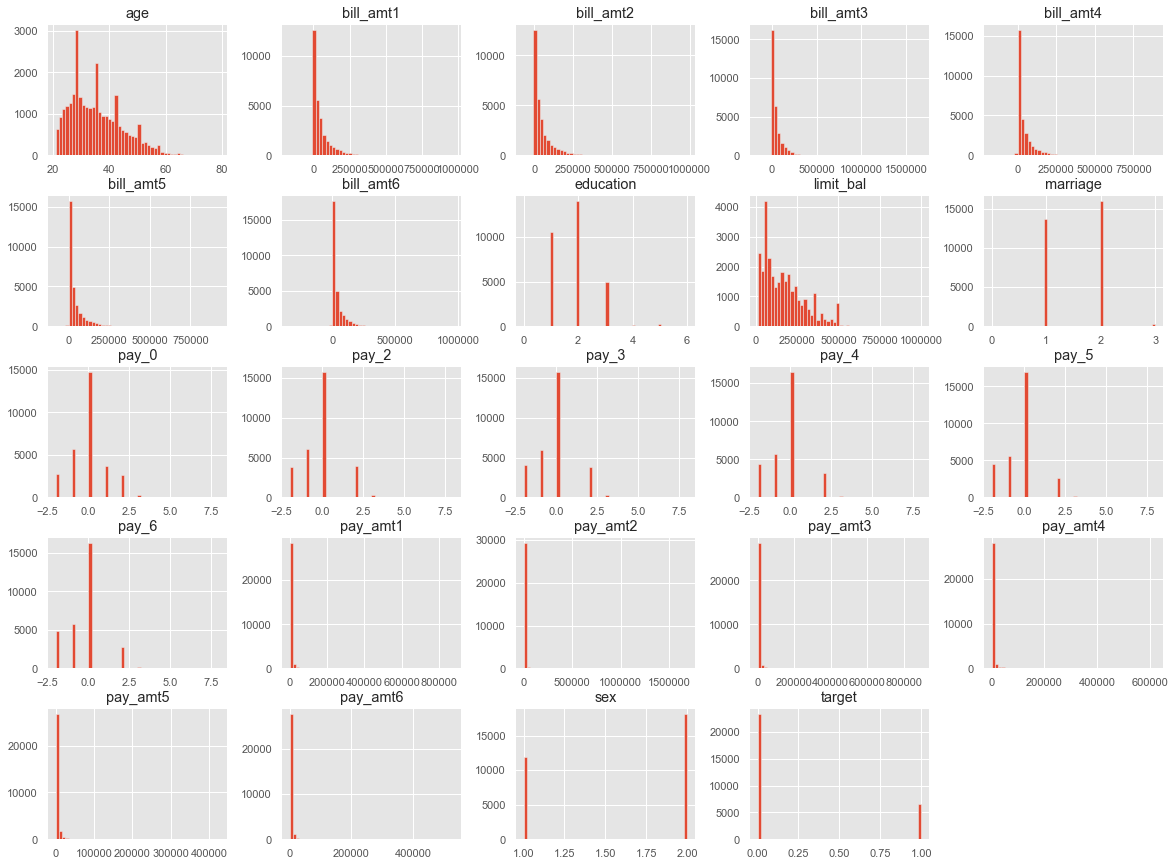

In [195]:
data.hist(bins = 50, figsize=(20,15))
plt.show()

All numerical data is right-skewed.<br>
Target feature values are biased to 0's

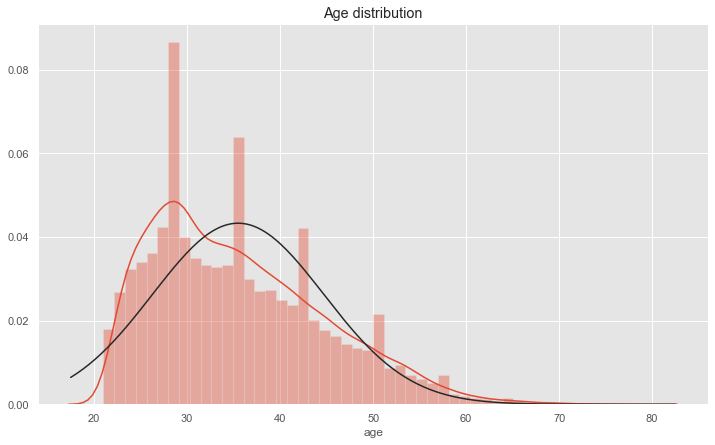

In [196]:
plt.figure(figsize = (12,7))
from scipy.stats import norm
sns.distplot(data.age, fit=norm, kde=True)
plt.title('Age distribution')
plt.show()

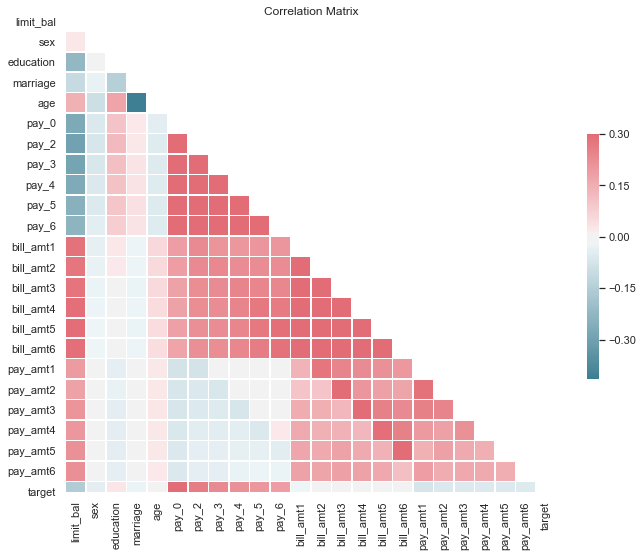

In [197]:
sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

As we can see, there are no hightly correlated features, therefore we do not drop any at this stage.

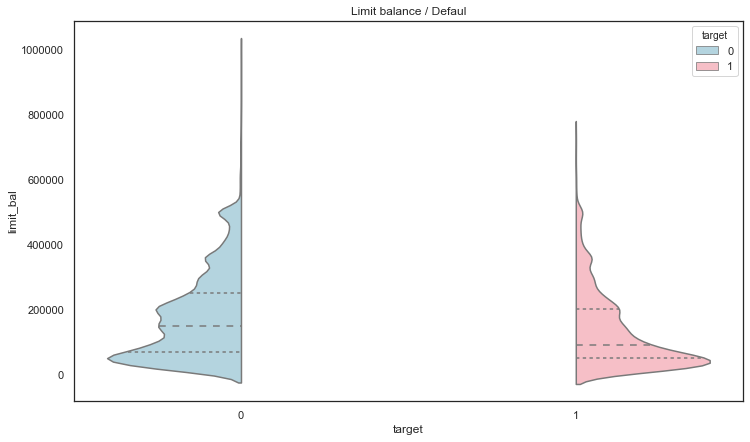

In [198]:
plt.figure(figsize = (12,7))
with sns.axes_style(style=None):
    sns.violinplot("target", "limit_bal", hue="target", data=data,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"]);
    
plt.title('Limit balance / Defaul')
plt.show()

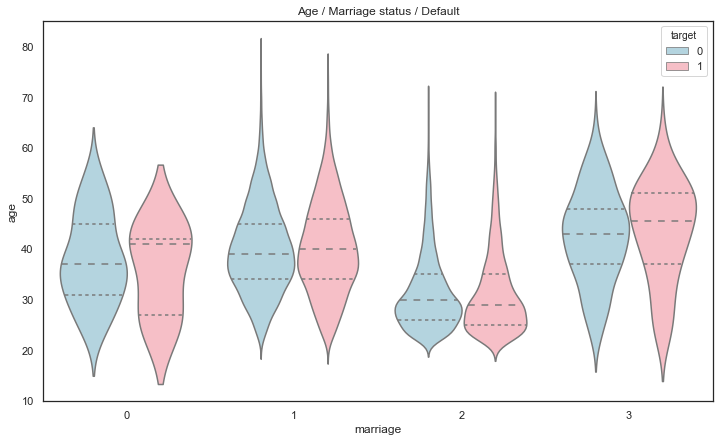

In [199]:
plt.figure(figsize = (12,7))
with sns.axes_style(style=None):
    sns.violinplot("marriage", "age", hue="target", data=data,
                   split=False, inner="quartile",
                   palette=["lightblue", "lightpink"]);
plt.title('Age / Marriage status / Default')
plt.show()

<h3>Data Preprocessing</h3>

In [200]:
data.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [201]:
def process_cols(df, cols_dict, sample=None):
    
    if sample is not None:
        n_examples = int(df.shape[0] * sample)
        df = df.sample(n_examples, random_state=42).reset_index(drop=True)
    
    d = {}
    cat_cols = []
    for ind, col in enumerate(df.columns): 
        if col != "target":
            if col in cols_dict["cat_cols"]:
                d[col] = f"cat_{ind}_{col}"
                cat_cols.append(f"cat_{ind}_{col}")
            else:
                d[col] = f"num_{ind}_{col}"
    df = df.rename(d, axis=1)
    for col in cat_cols:
        df[col] = df[col].fillna("new_category_nan")
        df[col] = df[col].astype("str")
    print("Tot cat columns : ", len(cat_cols))
    return df

In [202]:
cols_dict = {
    "id_cols": [],
    "cat_cols": [
        "sex", "education", "marriage", "pay_0",
        "pay_2", "pay_3", "pay_4", "pay_5", "pay_6"
    ], 
    "time_cols": []
}

In [203]:
data_pp = process_cols(data, cols_dict)
data_pp.head()

Tot cat columns :  9


,num_0_limit_bal,cat_1_sex,cat_2_education,cat_3_marriage,num_4_age,cat_5_pay_0,cat_6_pay_2,cat_7_pay_3,cat_8_pay_4,cat_9_pay_5,cat_10_pay_6,num_11_bill_amt1,num_12_bill_amt2,num_13_bill_amt3,num_14_bill_amt4,num_15_bill_amt5,num_16_bill_amt6,num_17_pay_amt1,num_18_pay_amt2,num_19_pay_amt3,num_20_pay_amt4,num_21_pay_amt5,num_22_pay_amt6,target
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [204]:
cat_cols = [x for x in data_pp.columns if 'cat_' in x]

<b>Count plots for categorical features:

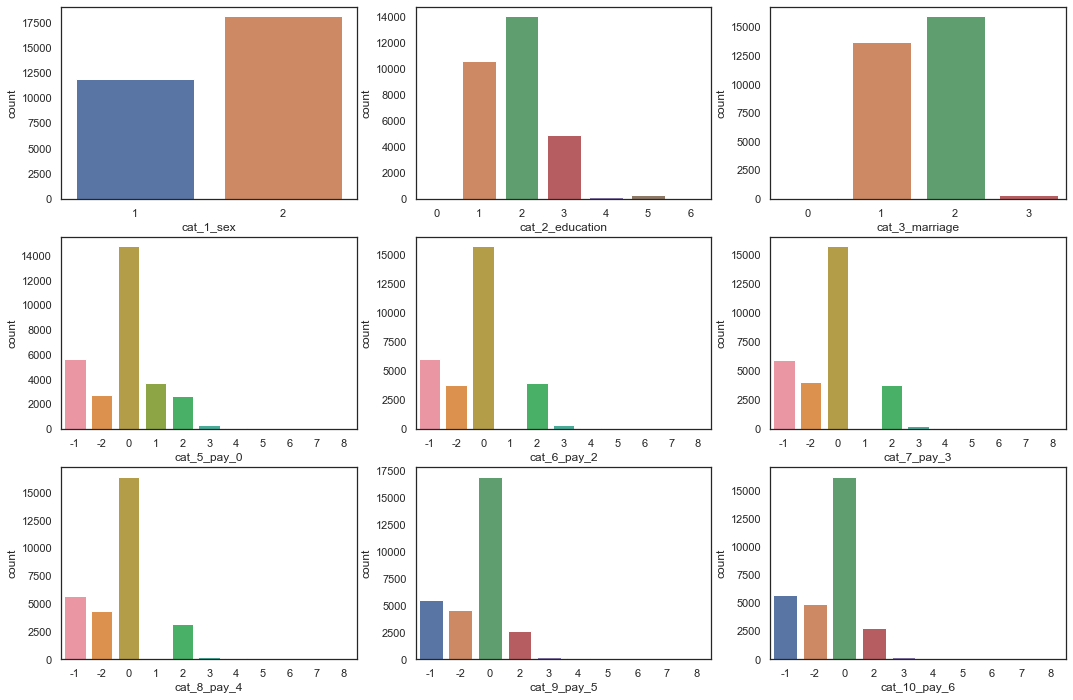

In [205]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12))
ax = ax.flatten()
for i, cat_col in enumerate(cat_cols):
    sns.countplot(data_pp[cat_col], ax=ax[i])
fig.show()

Here I tried different encoders. Let's keep with OneHotEncoder.

In [206]:
enc = OneHotEncoder(cols=cat_cols)
# enc = CatBoostEncoder(cols=cat_cols)
# enc = TargetEncoder(cols=cat_cols)

data_enc = enc.fit_transform(data_pp)

In [207]:
data_enc.head()

,num_0_limit_bal,cat_1_sex_1,cat_1_sex_2,cat_2_education_1,cat_2_education_2,cat_2_education_3,cat_2_education_4,cat_2_education_5,cat_2_education_6,cat_2_education_7,cat_3_marriage_1,cat_3_marriage_2,cat_3_marriage_3,cat_3_marriage_4,num_4_age,cat_5_pay_0_1,cat_5_pay_0_2,cat_5_pay_0_3,cat_5_pay_0_4,cat_5_pay_0_5,cat_5_pay_0_6,cat_5_pay_0_7,cat_5_pay_0_8,cat_5_pay_0_9,cat_5_pay_0_10,cat_5_pay_0_11,cat_6_pay_2_1,cat_6_pay_2_2,cat_6_pay_2_3,cat_6_pay_2_4,cat_6_pay_2_5,cat_6_pay_2_6,cat_6_pay_2_7,cat_6_pay_2_8,cat_6_pay_2_9,cat_6_pay_2_10,cat_6_pay_2_11,cat_7_pay_3_1,cat_7_pay_3_2,cat_7_pay_3_3,cat_7_pay_3_4,cat_7_pay_3_5,cat_7_pay_3_6,cat_7_pay_3_7,cat_7_pay_3_8,cat_7_pay_3_9,cat_7_pay_3_10,cat_7_pay_3_11,cat_8_pay_4_1,cat_8_pay_4_2,cat_8_pay_4_3,cat_8_pay_4_4,cat_8_pay_4_5,cat_8_pay_4_6,cat_8_pay_4_7,cat_8_pay_4_8,cat_8_pay_4_9,cat_8_pay_4_10,cat_8_pay_4_11,cat_9_pay_5_1,cat_9_pay_5_2,cat_9_pay_5_3,cat_9_pay_5_4,cat_9_pay_5_5,cat_9_pay_5_6,cat_9_pay_5_7,cat_9_pay_5_8,cat_9_pay_5_9,cat_9_pay_5_10,cat_10_pay_6_1,cat_10_pay_6_2,cat_10_pay_6_3,cat_10_pay_6_4,cat_10_pay_6_5,cat_10_pay_6_6,cat_10_pay_6_7,cat_10_pay_6_8,cat_10_pay_6_9,cat_10_pay_6_10,num_11_bill_amt1,num_12_bill_amt2,num_13_bill_amt3,num_14_bill_amt4,num_15_bill_amt5,num_16_bill_amt6,num_17_pay_amt1,num_18_pay_amt2,num_19_pay_amt3,num_20_pay_amt4,num_21_pay_amt5,num_22_pay_amt6,target
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,1,0,1,0,0,0,0,0,0,1,0,0,0,24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,1,0,1,0,0,0,0,0,0,0,1,0,0,26,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,1,0,1,0,0,0,0,0,0,0,1,0,0,34,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,1,0,1,0,0,0,0,0,0,1,0,0,0,37,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,0,1,1,0,0,0,0,0,0,1,0,0,0,57,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [208]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

<h3>Modeling

In [209]:
# import keras
import tensorflow as tf
# from keras import backend as K

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [210]:
def NN(X, y, n_epoch, test_size = 0.25):
    

    X_sc = StandardScaler().fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.25, random_state=1)
    
    model = Sequential()

    model.add(Dense(20, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.25))
    # model.add(BatchNormalization())
    # model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    # model.add(BatchNormalization())
    # model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation = 'sigmoid'))
    model.summary()
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy', tf.keras.metrics.AUC()])
    
    
    checkpoint = ModelCheckpoint('w.hdf5', monitor='val_loss', save_best_only=True)

    callback_list = [checkpoint]

    training = model.fit(X_train, y_train, 
              validation_split = 0.05,
              batch_size=50,
              epochs = n_epoch,
               callbacks = callback_list)


    model.load_weights('w.hdf5')
    print()
    print('######################################')
    print('Applying model to a validation set:')
    val = model.evaluate(X_test, y_test)
    
    print('Performance on validation set:')
    print('<--------------------------------------------------->')
    print('binary_crossentropy: ', val[0])
    print('binary_accuracy: ', val[1])
    print('ROC AUC: ', val[2])
    print('<--------------------------------------------------->')
    

    return training

In [211]:
X = data_enc.copy()
y = X.pop('target')

t = NN(X, y, n_epoch = 25, test_size = 0.25)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 20)                1840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________
Train on 21375 samples, validate on 1125 samples
Epoch 1/25
21375/21375 [==============================] - 2s 83us/step - loss: 0.4976 - binary_accuracy: 0.8017 - auc_5: 0.6791 - val_loss: 0.4472 - val_binary_accuracy: 0.8142 - val_auc_5: 0.7088
Epoch 2/25
21375/21375 [==============================] - 2s 71us/step - loss: 0.4443 - binary_accuracy: 0.8212 - auc_5: 0.7222 - val_lo

In [212]:
def plot_metrics(t):
    metric_list = [x for x in list(t.history.keys()) if 'auc' in x]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    ax1.set_title('Training Loss / Validation Loss')
    ax1.plot(t.history['loss'], 'tab:red', label='Training loss')
    ax1.legend(['A simple line'])
    ax1.plot(t.history['val_loss'], 'tab:blue', label='Validation loss')
    ax1.grid(color='grey', linestyle='-', linewidth=0.2)
    ax1.legend()
    for i, x in enumerate(metric_list):
        l = 'Validation AUC' if 'val' in x else 'Training AUC'
        ax2.plot(t.history[x], label = l)
    ax2.set_title('Training AUC / Validation AUC')
    ax2.grid(color='grey', linestyle='-', linewidth=0.2)
    ax2.legend()
    plt.show()

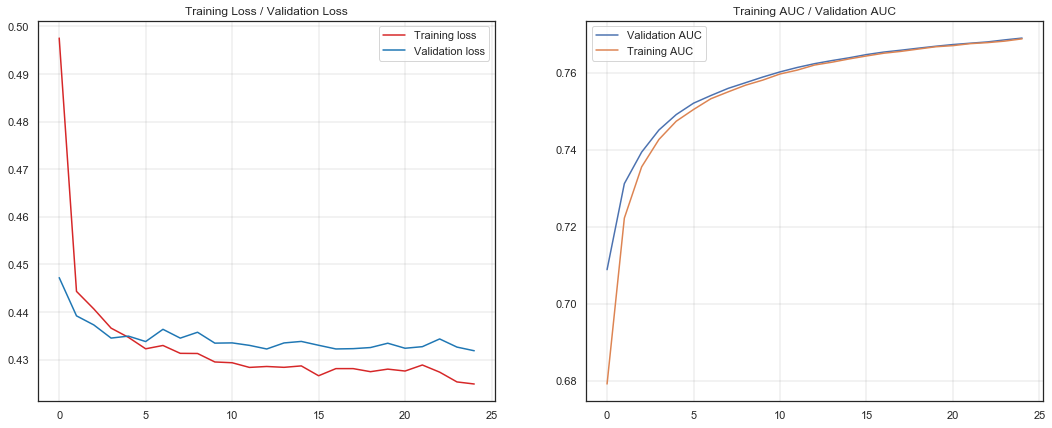

In [213]:
plot_metrics(t)

<b>XGBoost Classifier

Now, let's try another algorithm - XGBoost Classifier. It is known as a very efficient and less proned to overfitting ML method of classification.

In [214]:
import xgboost as xgb
from xgboost import XGBClassifier

In [215]:
model = XGBClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [216]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
predictions_proba = model.predict_proba(X_test)[:,1]

In [217]:
# y_pred

In [218]:
# predictions_proba

In [219]:
# evaluate predictions
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

accuracy = accuracy_score(y_test, predictions)
roc = roc_auc_score(y_test, predictions_proba)

print("\nModel Report (test set - base model)")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("AUC: %.2f%%" % (roc * 100.0))


Model Report (test set - base model)
Accuracy: 81.68%
AUC: 78.26%


In [220]:
def modelfit(alg, X_train, y_train, X_test, y_test, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    
    auc_test_score = roc_auc_score(y_test, alg.predict_proba(X_test)[:,1])
#     #Print model report:
#     print("\nModel Report (training set)")
#     print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
#     print("AUC Score (Train): %f" % roc_auc_score(y_train, dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    
    return alg, auc_test_score

In [221]:
#Choose all predictors except target & IDcols
predictors = [x for x in data_enc.columns if x != 'target']


xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb1_model, AUC = modelfit(xgb1, X_train, y_train, X_test, y_test, predictors)


In [222]:
xgb1_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=167, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [223]:
acc = accuracy_score(y_test, xgb1_model.predict(X_test))

print("\nModel Report (test set - tuned model)")
print("Accuracy: %.2f%%" % (acc * 100.0))
print("AUC: %.2f%%" % (AUC * 100.0))


Model Report (test set - tuned model)
Accuracy: 81.77%
AUC: 78.28%


<b>Bayesian Optimization<b>

In [224]:
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

def XGB_bayesian(max_depth,
                 min_child_weight,
                 subsample,
                 colsample_bytree,
                 gamma,
                 reg_alpha,
                 n_estimators,
                 learning_rate):
    
    xgb_opt = XGBClassifier(
         booster = 'gbtree',
         learning_rate = learning_rate,
         n_estimators = int(n_estimators),
         max_depth = int(max_depth),
         min_child_weight = int(min_child_weight),
         gamma = gamma,
         reg_alpha = reg_alpha,
         subsample = subsample,
         colsample_bytree = colsample_bytree,
         objective = 'binary:logistic',
         nthread = 10,
         scale_pos_weight = 1,
         seed = 88
    )
    

    alg, score = modelfit(xgb_opt, X_train, y_train, X_test, y_test, predictors)
    
    
    return score

In [225]:
# y

In [226]:
init_points = 16
n_iter = 16

In [227]:
bounds_XGB = {
    'n_estimators' : (30, 1300),
    'max_depth': (4, 12),
    'min_child_weight' : (4, 12),
    'gamma': (0, 0.5),
    'reg_alpha': (0.001, 100),
    'subsample': (0.6, 1),
    'colsample_bytree': (0.6, 1),
    'learning_rate': (0.05, 0.3)
}

XGB_BO = BayesianOptimization(XGB_bayesian, bounds_XGB, random_state=88)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    XGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.785    |  0.859    |  0.2536   |  0.1821   |  11.17    |  9.6      |  937.2    |  71.73    |  0.6891   |
|  2        |  0.7851   |  0.6701   |  0.2284   |  0.2822   |  4.079    |  4.719    |  1.11e+03 |  48.56    |  0.9507   |
|  3        |  0.7841   |  0.7229   |  0.194    |  0.1954   |  4.909    |  10.14    |  427.0    |  64.6     |  0.6131   |
|  4        |  0.7823   |  0.6666   |  0.2152   |  0.107    |  11.73    |  11.24    |  1.129e+0 |  3.217    |  0.9198   |
|  5        |  0.7841   |  0.9625   |  0.352    |  0.1074   |  7.291    |  11.83    |  447.9    |  59.55    |  0.8143   |
|  6        |  0.7837   |  0.7844   |  0.1129   |  0.2801   |  8.887    |  5.761    |  79.89    |  54.79    |  0.6361   |
|  7        |  0.7851   

In [228]:
XGB_BO.max['params']

{'colsample_bytree': 0.7915617594582369,
 'gamma': 0.12125613878619096,
 'learning_rate': 0.17133280943442225,
 'max_depth': 11.856833758278098,
 'min_child_weight': 4.05698107893157,
 'n_estimators': 1216.6948015595399,
 'reg_alpha': 50.016574772077725,
 'subsample': 0.7120272908605803}

In [229]:
xgb_optimized = XGBClassifier(
 learning_rate = XGB_BO.max['params']['learning_rate'],
 n_estimators = int(XGB_BO.max['params']['n_estimators']),
 max_depth = int(XGB_BO.max['params']['max_depth']),
 min_child_weight = int(XGB_BO.max['params']['min_child_weight']),
 gamma = XGB_BO.max['params']['gamma'],
 subsample = XGB_BO.max['params']['subsample'],
 colsample_bytree = XGB_BO.max['params']['colsample_bytree'],
 objective = 'binary:logistic',
 reg_alpha = XGB_BO.max['params']['reg_alpha'],
 nthread = 10,
 scale_pos_weight = 1,
 seed = 27,
 n_jobs = -1)

xgb_optimized.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7915617594582369,
              gamma=0.12125613878619096, learning_rate=0.17133280943442225,
              max_delta_step=0, max_depth=11, min_child_weight=4, missing=None,
              n_estimators=1216, n_jobs=-1, nthread=10,
              objective='binary:logistic', random_state=0,
              reg_alpha=50.016574772077725, reg_lambda=1, scale_pos_weight=1,
              seed=27, silent=None, subsample=0.7120272908605803, verbosity=1)

In [230]:
print("\nModel Report (test set - optimized model)")
print("Accuracy: %.2f%%" % (accuracy_score(y_test, xgb_optimized.predict(X_test)) * 100.0))
print("AUC: %.2f%%" % (roc_auc_score(y_test, xgb_optimized.predict_proba(X_test)[:,1]) * 100.0))


Model Report (test set - optimized model)
Accuracy: 81.85%
AUC: 78.39%


In [231]:
def group_encoded(initial_cat_cols, importance_dict):
    
    gr_dict = {}
    to_del = []
    
    for cat in initial_cat_cols:
#         und_inx = find(cat, '_')
#         cat_name = cat[:(und_inx[-1])] if len(und_inx) > 2 else cat
        cat_name = cat
        
        k = 0
        for enc_cat, value in importance_dict.items():
            if cat_name in enc_cat:
                k += value
                to_del.append(enc_cat)
                
            gr_dict.update({cat_name:k})
    for cat in to_del:
        importance_dict.pop(cat)
    gr_dict.update(importance_dict)
    
    return gr_dict

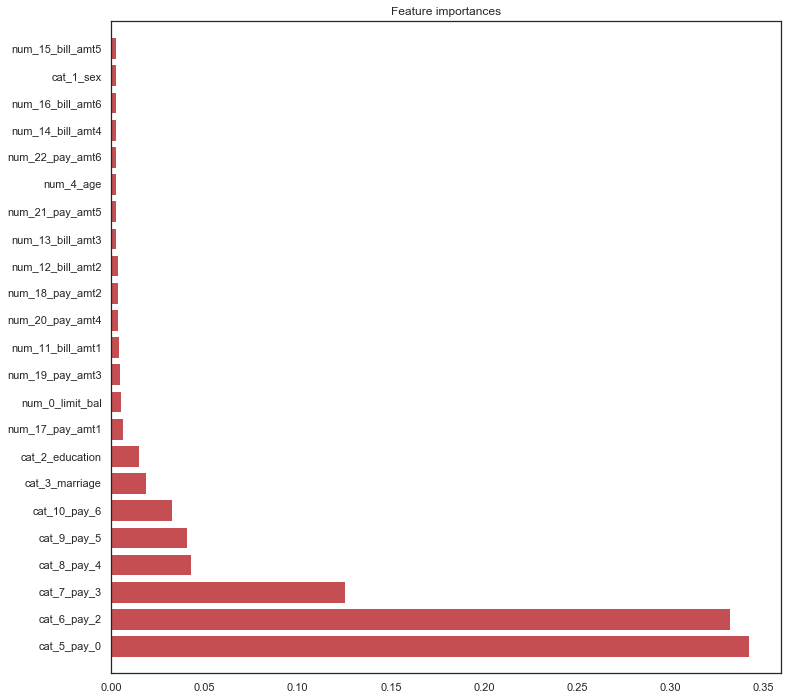

In [232]:
imp_dict = dict(zip(X_train.columns, xgb_optimized.feature_importances_))

gr = group_encoded(cat_cols, imp_dict)
# non_zero_imp = {k:v for k,v in imp_dict.items() if v != 0}

sorted_dict = sorted(gr.items(), key=lambda kv: kv[1], reverse = True)

x, y = zip(*sorted_dict) 

plt.figure(figsize=(12,12))
plt.barh(x, y, color="r", align="center")
plt.title("Feature importances")
plt.ylim([-1, len(sorted_dict)])
plt.show()


<b>Feature Engineering</b>

In [252]:
X_pca = data_enc.copy()

In [253]:
X_pca

,num_0_limit_bal,cat_1_sex_1,cat_1_sex_2,cat_2_education_1,cat_2_education_2,cat_2_education_3,cat_2_education_4,cat_2_education_5,cat_2_education_6,cat_2_education_7,cat_3_marriage_1,cat_3_marriage_2,cat_3_marriage_3,cat_3_marriage_4,num_4_age,cat_5_pay_0_1,cat_5_pay_0_2,cat_5_pay_0_3,cat_5_pay_0_4,cat_5_pay_0_5,cat_5_pay_0_6,cat_5_pay_0_7,cat_5_pay_0_8,cat_5_pay_0_9,cat_5_pay_0_10,cat_5_pay_0_11,cat_6_pay_2_1,cat_6_pay_2_2,cat_6_pay_2_3,cat_6_pay_2_4,cat_6_pay_2_5,cat_6_pay_2_6,cat_6_pay_2_7,cat_6_pay_2_8,cat_6_pay_2_9,cat_6_pay_2_10,cat_6_pay_2_11,cat_7_pay_3_1,cat_7_pay_3_2,cat_7_pay_3_3,cat_7_pay_3_4,cat_7_pay_3_5,cat_7_pay_3_6,cat_7_pay_3_7,cat_7_pay_3_8,cat_7_pay_3_9,cat_7_pay_3_10,cat_7_pay_3_11,cat_8_pay_4_1,cat_8_pay_4_2,cat_8_pay_4_3,cat_8_pay_4_4,cat_8_pay_4_5,cat_8_pay_4_6,cat_8_pay_4_7,cat_8_pay_4_8,cat_8_pay_4_9,cat_8_pay_4_10,cat_8_pay_4_11,cat_9_pay_5_1,cat_9_pay_5_2,cat_9_pay_5_3,cat_9_pay_5_4,cat_9_pay_5_5,cat_9_pay_5_6,cat_9_pay_5_7,cat_9_pay_5_8,cat_9_pay_5_9,cat_9_pay_5_10,cat_10_pay_6_1,cat_10_pay_6_2,cat_10_pay_6_3,cat_10_pay_6_4,cat_10_pay_6_5,cat_10_pay_6_6,cat_10_pay_6_7,cat_10_pay_6_8,cat_10_pay_6_9,cat_10_pay_6_10,num_11_bill_amt1,num_12_bill_amt2,num_13_bill_amt3,num_14_bill_amt4,num_15_bill_amt5,num_16_bill_amt6,num_17_pay_amt1,num_18_pay_amt2,num_19_pay_amt3,num_20_pay_amt4,num_21_pay_amt5,num_22_pay_amt6,target
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,1,0,1,0,0,0,0,0,0,1,0,0,0,24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,1,0,1,0,0,0,0,0,0,0,1,0,0,26,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,1,0,1,0,0,0,0,0,0,0,1,0,0,34,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,1,0,1,0,0,0,0,0,0,1,0,0,0,37,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,0,1,1,0,0,0,0,0,0,1,0,0,0,57,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,0,1,0,0,1,0,0,0,0,1,0,0,0,39,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,0,1,0,0,1,0,0,0,0,0,1,0,0,43,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,0,1,1,0,0,0,0,0,0,0,1,0,0,37,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [254]:
from sklearn.decomposition import PCA
import sklearn

In [255]:
pca = PCA(n_components = 0.98, svd_solver = 'auto', random_state = 2019)

In [256]:
pca

PCA(copy=True, iterated_power='auto', n_components=0.98, random_state=2019,
    svd_solver='auto', tol=0.0, whiten=False)

In [257]:
y = X_pca.pop('target')

X_pca = pca.fit_transform(X_pca)  

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

[0.61043701 0.29535381 0.03052419 0.01692859 0.00942042 0.00904175
 0.00754446 0.00638481]
[28841272.564776   20061586.76019501  6449352.00479843  4802909.64137151
  3582853.95205178  3510105.15824992  3206328.4556978   2949633.84266448]


In [258]:
t2 = NN(X_pca, y, 25, test_size = 0.15)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 20)                180       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 21        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
Train on 21375 samples, validate on 1125 samples
Epoch 1/25
21375/21375 [==============================] - 2s 82us/step - loss: 0.5574 - binary_accuracy: 0.7785 - auc_6: 0.5430 - val_loss: 0.5278 - val_binary_accuracy: 0.7671 - val_auc_6: 0.5571
Epoch 2/25
21375/21375 [==============================] - 1s 70us/step - loss: 0.5146 - binary_accuracy: 0.7798 - auc_6: 0.5734 - val_loss: 

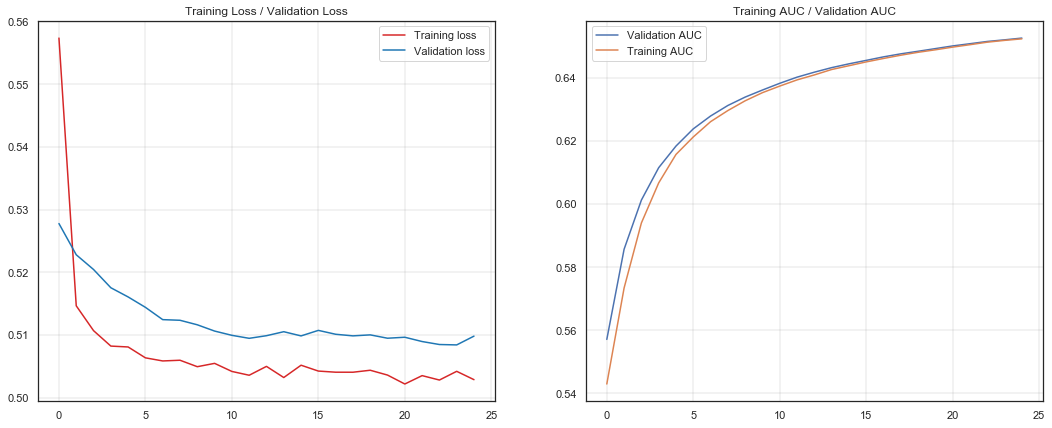

In [259]:
plot_metrics(t2)

<b>Adding new features</b>

In [260]:
X_feat = data_enc.copy()

<b>F1

In [261]:
bill_cols = [col for col in X_feat.columns if 'bill_amt' in col]
pay_cols = [col for col in X_feat.columns if 'pay_amt' in col]


X_feat['num_bill_atm_mean'] = X_feat.loc[:,bill_cols].mean(axis = 1)
X_feat['num_pay_atm_mean'] = X_feat.loc[:,pay_cols].mean(axis = 1)

<b>F2

In [262]:
X_feat['limit_to_first_bill_amt'] = X_feat['num_16_bill_amt6'] / X_feat['num_0_limit_bal']

In [263]:
X_feat['limit_to_first_bill_amt'].isnull().sum()

0

<b>F3

In [264]:
X_feat['first_bill_pay_diff'] = X_feat['num_16_bill_amt6'] - X_feat['num_22_pay_amt6']
X_feat['second_bill_pay_diff'] = X_feat['num_15_bill_amt5'] - X_feat['num_21_pay_amt5']

In [265]:
y2 = X_feat.pop('target')

t3 = NN(X_feat, y2, n_epoch = 25, test_size = 0.15)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                1940      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 21        
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________
Train on 21375 samples, validate on 1125 samples
Epoch 1/25
21375/21375 [==============================] - 2s 76us/step - loss: 0.4840 - binary_accuracy: 0.8043 - auc_7: 0.6307 - val_loss: 0.4403 - val_binary_accuracy: 0.8169 - val_auc_7: 0.7126
Epoch 2/25
21375/21375 [==============================] - 1s 68us/step - loss: 0.4395 - binary_accuracy: 0.8204 - auc_7: 0.7291 - val_lo

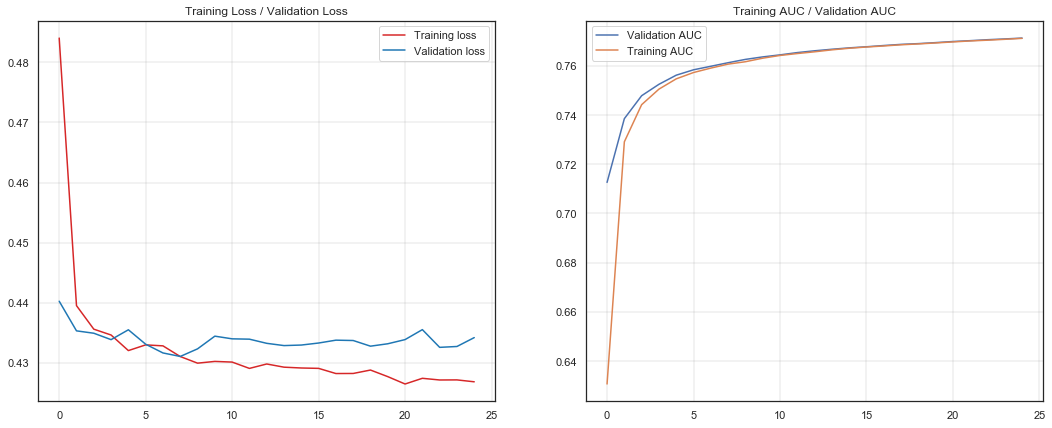

In [266]:
plot_metrics(t3)

In [267]:
# X_feat

<b>Feature Reducing</b>

In [268]:
X_pp = data_pp.copy()

X_pp.loc[X_pp['cat_2_education'].isin(['4','5','6']), 'cat_2_education'] = '0' 

In [269]:
X_pp.cat_2_education.value_counts()

2    14030
1    10585
3     4917
0      468
Name: cat_2_education, dtype: int64

In [270]:
data_enc_fe = enc.fit_transform(X_pp, X_pp['target'])

In [271]:
data_enc_fe

,num_0_limit_bal,cat_1_sex_1,cat_1_sex_2,cat_2_education_1,cat_2_education_2,cat_2_education_3,cat_2_education_4,cat_3_marriage_1,cat_3_marriage_2,cat_3_marriage_3,cat_3_marriage_4,num_4_age,cat_5_pay_0_1,cat_5_pay_0_2,cat_5_pay_0_3,cat_5_pay_0_4,cat_5_pay_0_5,cat_5_pay_0_6,cat_5_pay_0_7,cat_5_pay_0_8,cat_5_pay_0_9,cat_5_pay_0_10,cat_5_pay_0_11,cat_6_pay_2_1,cat_6_pay_2_2,cat_6_pay_2_3,cat_6_pay_2_4,cat_6_pay_2_5,cat_6_pay_2_6,cat_6_pay_2_7,cat_6_pay_2_8,cat_6_pay_2_9,cat_6_pay_2_10,cat_6_pay_2_11,cat_7_pay_3_1,cat_7_pay_3_2,cat_7_pay_3_3,cat_7_pay_3_4,cat_7_pay_3_5,cat_7_pay_3_6,cat_7_pay_3_7,cat_7_pay_3_8,cat_7_pay_3_9,cat_7_pay_3_10,cat_7_pay_3_11,cat_8_pay_4_1,cat_8_pay_4_2,cat_8_pay_4_3,cat_8_pay_4_4,cat_8_pay_4_5,cat_8_pay_4_6,cat_8_pay_4_7,cat_8_pay_4_8,cat_8_pay_4_9,cat_8_pay_4_10,cat_8_pay_4_11,cat_9_pay_5_1,cat_9_pay_5_2,cat_9_pay_5_3,cat_9_pay_5_4,cat_9_pay_5_5,cat_9_pay_5_6,cat_9_pay_5_7,cat_9_pay_5_8,cat_9_pay_5_9,cat_9_pay_5_10,cat_10_pay_6_1,cat_10_pay_6_2,cat_10_pay_6_3,cat_10_pay_6_4,cat_10_pay_6_5,cat_10_pay_6_6,cat_10_pay_6_7,cat_10_pay_6_8,cat_10_pay_6_9,cat_10_pay_6_10,num_11_bill_amt1,num_12_bill_amt2,num_13_bill_amt3,num_14_bill_amt4,num_15_bill_amt5,num_16_bill_amt6,num_17_pay_amt1,num_18_pay_amt2,num_19_pay_amt3,num_20_pay_amt4,num_21_pay_amt5,num_22_pay_amt6,target
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,1,0,1,0,0,0,1,0,0,0,24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,1,0,1,0,0,0,0,1,0,0,26,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,1,0,1,0,0,0,0,1,0,0,34,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,1,0,1,0,0,0,1,0,0,0,37,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,0,1,1,0,0,0,1,0,0,0,57,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,0,1,0,0,1,0,1,0,0,0,39,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,0,1,0,0,1,0,0,1,0,0,43,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,0,1,1,0,0,0,0,1,0,0,37,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [272]:
y3 = data_enc_fe.pop('target')

t4 = NN(data_enc_fe, y3, n_epoch = 25, test_size = 0.15)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 20)                1780      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 21        
Total params: 1,801
Trainable params: 1,801
Non-trainable params: 0
_________________________________________________________________
Train on 21375 samples, validate on 1125 samples
Epoch 1/25
21375/21375 [==============================] - 2s 79us/step - loss: 0.4843 - binary_accuracy: 0.8024 - auc_8: 0.6725 - val_loss: 0.4411 - val_binary_accuracy: 0.8240 - val_auc_8: 0.7161
Epoch 2/25
21375/21375 [==============================] - 1s 70us/step - loss: 0.4416 - binary_accuracy: 0.8209 - auc_8: 0.7281 - val_lo

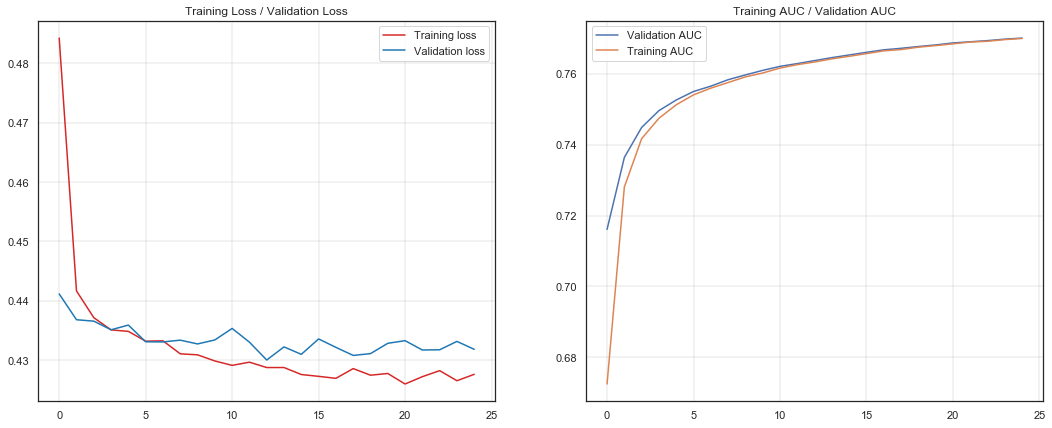

In [273]:
plot_metrics(t4)

<b>Log Transformation

In [274]:
X_log = data_enc.copy()

cols_to_transform = [col for col in X_log.columns if 'num' in col]

for c in cols_to_transform:
    X_log[c] = np.log10(X_log[c])
    
X_log = X_log.replace([np.inf, -np.inf], 0)


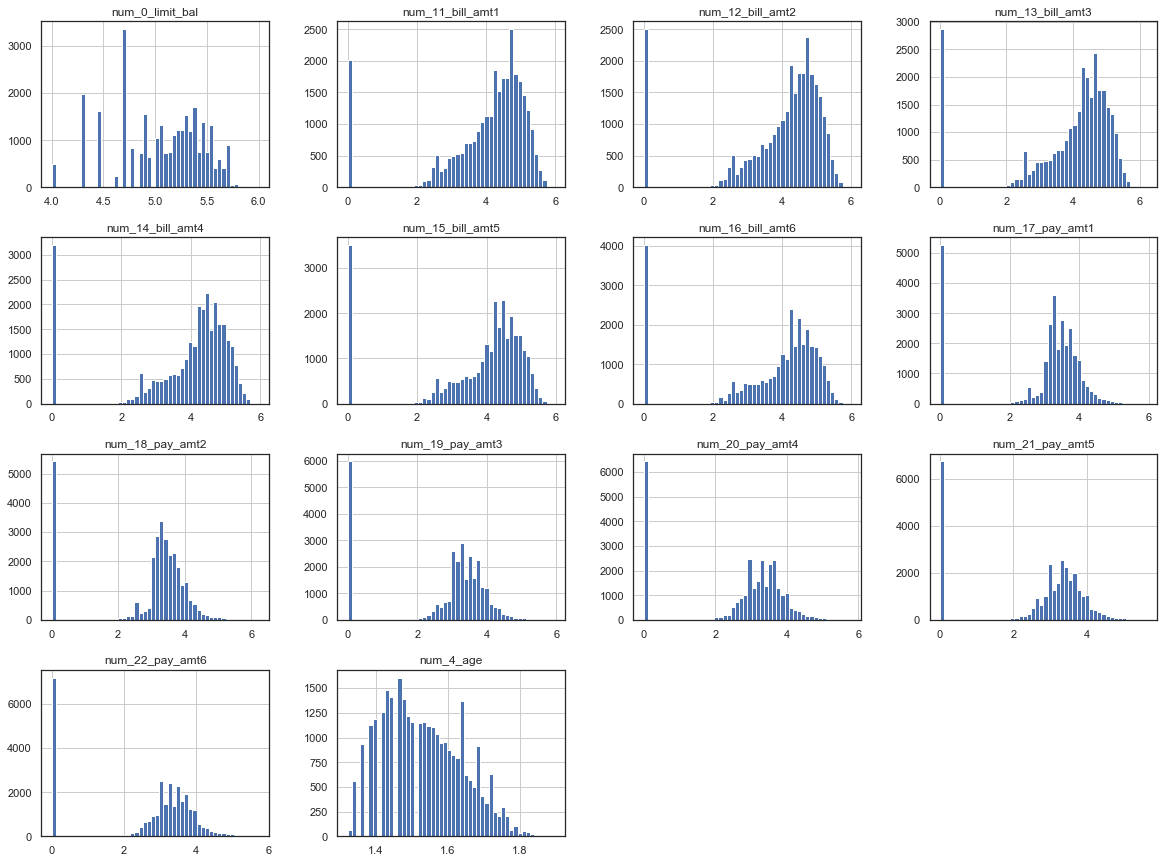

In [275]:
X_log[cols_to_transform].hist(bins = 50, figsize=(20,15))
plt.show()

In [276]:
X_log.head()

,num_0_limit_bal,cat_1_sex_1,cat_1_sex_2,cat_2_education_1,cat_2_education_2,cat_2_education_3,cat_2_education_4,cat_2_education_5,cat_2_education_6,cat_2_education_7,cat_3_marriage_1,cat_3_marriage_2,cat_3_marriage_3,cat_3_marriage_4,num_4_age,cat_5_pay_0_1,cat_5_pay_0_2,cat_5_pay_0_3,cat_5_pay_0_4,cat_5_pay_0_5,cat_5_pay_0_6,cat_5_pay_0_7,cat_5_pay_0_8,cat_5_pay_0_9,cat_5_pay_0_10,cat_5_pay_0_11,cat_6_pay_2_1,cat_6_pay_2_2,cat_6_pay_2_3,cat_6_pay_2_4,cat_6_pay_2_5,cat_6_pay_2_6,cat_6_pay_2_7,cat_6_pay_2_8,cat_6_pay_2_9,cat_6_pay_2_10,cat_6_pay_2_11,cat_7_pay_3_1,cat_7_pay_3_2,cat_7_pay_3_3,cat_7_pay_3_4,cat_7_pay_3_5,cat_7_pay_3_6,cat_7_pay_3_7,cat_7_pay_3_8,cat_7_pay_3_9,cat_7_pay_3_10,cat_7_pay_3_11,cat_8_pay_4_1,cat_8_pay_4_2,cat_8_pay_4_3,cat_8_pay_4_4,cat_8_pay_4_5,cat_8_pay_4_6,cat_8_pay_4_7,cat_8_pay_4_8,cat_8_pay_4_9,cat_8_pay_4_10,cat_8_pay_4_11,cat_9_pay_5_1,cat_9_pay_5_2,cat_9_pay_5_3,cat_9_pay_5_4,cat_9_pay_5_5,cat_9_pay_5_6,cat_9_pay_5_7,cat_9_pay_5_8,cat_9_pay_5_9,cat_9_pay_5_10,cat_10_pay_6_1,cat_10_pay_6_2,cat_10_pay_6_3,cat_10_pay_6_4,cat_10_pay_6_5,cat_10_pay_6_6,cat_10_pay_6_7,cat_10_pay_6_8,cat_10_pay_6_9,cat_10_pay_6_10,num_11_bill_amt1,num_12_bill_amt2,num_13_bill_amt3,num_14_bill_amt4,num_15_bill_amt5,num_16_bill_amt6,num_17_pay_amt1,num_18_pay_amt2,num_19_pay_amt3,num_20_pay_amt4,num_21_pay_amt5,num_22_pay_amt6,target
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.301030,1,0,1,0,0,0,0,0,0,1,0,0,0,1.380211,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.592510,3.491642,2.838219,0.000000,0.000000,0.000000,0.000000,2.838219,0.000000,0.000000,0.000000,0.00000,1
2,5.079181,1,0,1,0,0,0,0,0,0,0,1,0,0,1.414973,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.428459,3.236789,3.428459,3.514813,3.538448,3.513351,0.000000,3.000000,3.000000,3.000000,0.000000,3.30103,1
3,4.954243,1,0,1,0,0,0,0,0,0,0,1,0,0,1.531479,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4.465963,4.146965,4.132228,4.156276,4.174583,4.191702,3.181272,3.176091,3.000000,3.000000,3.000000,3.69897,0
4,4.698970,1,0,1,0,0,0,0,0,0,1,0,0,0,1.568202,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4.672005,4.683344,4.692768,4.452001,4.461784,4.470513,3.301030,3.305136,3.079181,3.041393,3.028978,3.00000,0
5,4.698970,0,1,1,0,0,0,0,0,0,1,0,0,0,1.755875,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3.935356,3.753583,4.554307,4.320977,4.282078,4.281738,3.301030,4.564441,4.000000,3.954243,2.838219,2.83187,0


In [277]:
y4 = X_log.pop('target')

t5 = NN(X_log, y4, n_epoch = 25, test_size = 0.15)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 20)                1840      
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 21        
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________
Train on 21375 samples, validate on 1125 samples
Epoch 1/25
21375/21375 [==============================] - 2s 80us/step - loss: 0.6440 - binary_accuracy: 0.7792 - auc_9: 0.5028 - val_loss: 0.6089 - val_binary_accuracy: 0.7671 - val_auc_9: 0.4998
Epoch 2/25
21375/21375 [==============================] - 2s 73us/step - loss: 0.5793 - binary_accuracy: 0.7798 - auc_9: 0.5012 - val_l

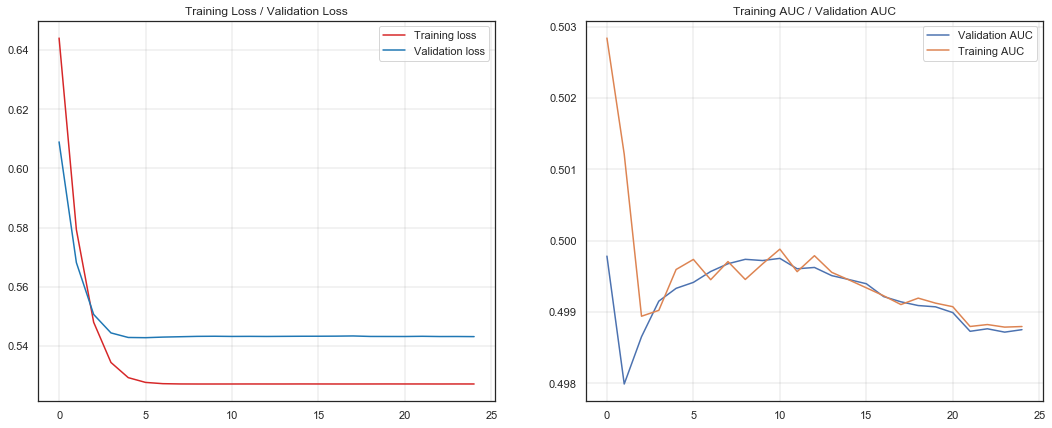

In [278]:
plot_metrics(t5)

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y4, test_size=0.25, random_state=1)

In [280]:
model = XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [281]:
print("\nModel Report (test set - optimized model)")
print("Accuracy: %.2f%%" % (accuracy_score(y_test, model.predict(X_test)) * 100.0))
print("AUC: %.2f%%" % (roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) * 100.0))


Model Report (test set - optimized model)
Accuracy: 81.79%
AUC: 78.33%


In [282]:
# def find(s, ch):
#     return [i for i, ltr in enumerate(s) if ltr == ch]

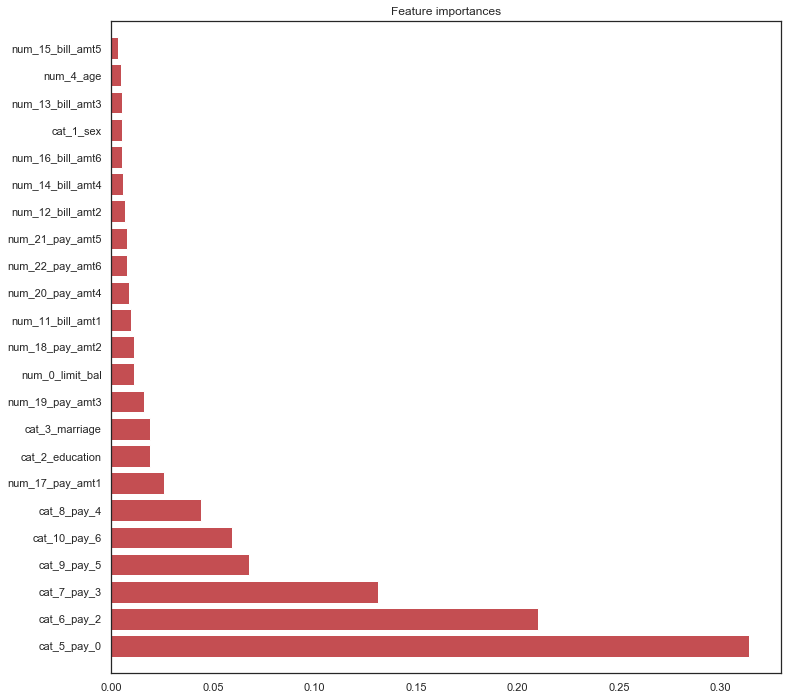

In [283]:
imp_dict = dict(zip(X_log.columns,model.feature_importances_))

gr = group_encoded(cat_cols, imp_dict)
# non_zero_imp = {k:v for k,v in imp_dict.items() if v != 0}

sorted_dict = sorted(gr.items(), key=lambda kv: kv[1], reverse = True)

x, y = zip(*sorted_dict) 

plt.figure(figsize=(12,12))
plt.barh(x, y, color="r", align="center")
plt.title("Feature importances")
plt.ylim([-1, len(sorted_dict)])
plt.show()


<h3>Conclusion

This notebook covers following analysis procedures:
- EDA
- Data Preprocessing
- Modeling : Sequential Neutal Network
- Modeling : XGBoosting Classifier
- Bayesian Optimization
- PCA
- Feature Reducing
- Feature Engineering (including Logarifmic Transformation)

<b>Inferences:</b>
- EDA does not give a clear understanding of which feature influences the target value the most.
- NN performs slightly worse than XGB Classifier on validation dataset, yet both algorithms give roughly similar binary accuracy - 81.8% and ROC AUC score around 77%.
- Undertaken feature engineering did not bring any improvement. Moreover, applying Logarithmic Transformation to numerical features gives ROC AUC score around 0.5 that makes it totally useless.
- According to XGB Classifier's feature importance, the most influential features are:
    1. PAY_0 
    2. PAY_2
    3. PAY_3
- That means that neither age nor education or sex does not influence on whether the person is going to be default or not.